In [3]:
import os
import imageio.v2 as imageio
from glob import glob
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot as plt
from hipposlam.Replay import ReplayMemoryAWAC
from hipposlam.utils import read_pickle
from os.path import join
import skvideo


# Animation Writer

In [4]:



class ModelTrajAnimator:
    def __init__(self, model_name, load_csv_pth):
        self.model_name = model_name
        self.df = pd.read_csv(load_csv_pth)
        self.x_norm = 6
        self.y_norm = 4
        self.xr = [-6.2, 6.8]
        self.yr = [-3.1, 4.9]
        self.goalx, self.goaly = (-4, -2)
        
    
    def plot_all_episode_trajs(self, save_episodes_dir, only_done=False):
        # View all episode trajectories
        
        unique_epis = self.df['i'].unique()
        for epi in unique_epis:
            
            subdf = self.df[self.df['i'] == epi]
            done = subdf['done'].to_numpy()[-1]
            if only_done and (done != 1) :
                continue
                
            # print(f'{epi}/{len(unique_epis)}, saving at {save_episodes_dir}')
            trajdata = subdf[['x', 'y', 'cosa', 'sina']].to_numpy()

            x, y, cosa, sina = trajdata[:, 0], trajdata[:, 1], trajdata[:, 2], trajdata[:, 3]
            x = x * self.x_norm
            y = y * self.y_norm
            
            dist = np.sum(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2))
            
            fig, ax = plt.subplots()
            ax.plot(x, y)
            ax.quiver(x[-1], y[-1], cosa[-1], sina[-1])
            # ax.scatter(self.goalx, self.goaly, marker='^', color='r')
            ax.plot([-4, self.xr[0]], [-0.5, -0.5], color='r')

            
            ax.set_xlim(*self.xr)
            ax.set_ylim(*self.yr)
            ax.set_title(f'episode {epi}, time={trajdata.shape[0]}, dist={dist:0.4f}')
            # ax.axis('off')
            fig.tight_layout()
            fig.savefig(join(save_episodes_dir, f'{epi}.png'), dpi=300)
            plt.close(fig)
    
    def plot_imgs_for_gif(self, save_gif_dir, epi): 
        # epi = 46 for random agent

        print('Saving images for gif at ', save_gif_dir)
        
        trajdata = self.df[self.df['i'] == epi][['x', 'y', 'cosa', 'sina']].to_numpy()
        x, y, cosa, sina = trajdata[:, 0], trajdata[:, 1], trajdata[:, 2], trajdata[:, 3]
        x = x * self.x_norm
        y = y * self.y_norm
        
        for t in range(trajdata.shape[0]):
            
            x2, y2, cosa2, sina2 = x[:t], y[:t], cosa[:t], sina[:t]
            
            fig, ax = plt.subplots()
            ax.plot(x2, y2)
            if t > 0 :
                ax.quiver(x2[-1], y2[-1], cosa2[-1], sina2[-1], scale=20, zorder=3.1)
            else:
                ax.quiver(x2, y2, cosa2, sina2, scale=20, zorder=3.1)
            
            # ax.scatter(self.goalx, self.goaly, marker='^', color='r')
            ax.plot([-4, self.xr[0]], [-0.5, -0.5], color='r')
            ax.set_xlim(*self.xr)
            ax.set_ylim(*self.yr)
            # ax.axis('off')
            fig.tight_layout()
            fig.savefig(join(save_gif_dir, f'{t}.png'), dpi=300)
            plt.close(fig)
            
    def generate_gif(self, load_pngs_dir, model_name):
        pths = glob(join(load_pngs_dir, '*.png'))
        Npths = len(pths)
        with imageio.get_writer(join(load_pngs_dir, f'{model_name}.gif'), mode='I', loop=1) as writer:
            for i in range(Npths):
                imgpth = join(load_pngs_dir, f'{i}.png')
                image = imageio.imread(imgpth)
                writer.append_data(image)
    def generate_mp4(self, load_pngs_dir, model_name):
        pths = glob(join(load_pngs_dir, '*.png'))
        Npths = len(pths)
        writer = skvideo.io.FFmpegWriter(join(load_pngs_dir, f'{model_name}.wmv'))
        for i in range(Npths):
            imgpth = join(load_pngs_dir, f'{i}.png')
            image = imageio.imread(imgpth)
            writer.writeFrame(image)
        writer.close()
        
    

# Plot Random Agent

In [5]:
model_name = 'RandomAgent'
load_csv_pth = 'data/%s/%s_TrajectoryRecords.csv' %(model_name, model_name)
save_episodes_dir = 'data/%s/episode_overview' % (model_name)
os.makedirs(save_episodes_dir, exist_ok=True)


MTA = ModelTrajAnimator(model_name=model_name, load_csv_pth=load_csv_pth)
# MTA.plot_all_episode_trajs(save_episodes_dir)


In [6]:
epi=46
save_gif_dir = 'data/%s/%d_gif'%(model_name, epi)
os.makedirs(save_gif_dir, exist_ok=True)
# MTA.plot_imgs_for_gif(save_gif_dir=save_gif_dir, epi=epi)
MTA.generate_mp4(load_pngs_dir=save_gif_dir, model_name=model_name)
# 

In [7]:
pths = glob(join(save_gif_dir, '*.png'))
Npths = len(pths)
writer = skvideo.io.FFmpegWriter(join(save_gif_dir, f'{model_name}.wmv'))
for i in range(Npths):
    imgpth = join(save_gif_dir, f'{i}.png')
    image = imageio.imread(imgpth)
    writer.writeFrame(image)
writer.close()

# Plot Naive avoidance

In [8]:
model_name = 'NaiveControllerDemo'
load_csv_pth = 'data/%s/%s_TrajectoryRecords.csv' %(model_name, model_name)
save_episodes_dir = 'data/%s/episode_overview' % (model_name)
os.makedirs(save_episodes_dir, exist_ok=True)

MTA = ModelTrajAnimator(model_name=model_name, load_csv_pth=load_csv_pth)
# MTA.plot_all_episode_trajs(save_episodes_dir, only_done=True)



In [9]:
epi = 1211  # 1211, 1065
save_gif_dir = 'data/%s/%d_gif'%(model_name, epi)
os.makedirs(save_gif_dir, exist_ok=True)
# MTA.plot_imgs_for_gif(save_gif_dir=save_gif_dir, epi=epi)
MTA.generate_mp4(load_pngs_dir=save_gif_dir, model_name=model_name)


# Plot OfflineTrained

In [10]:
model_name = 'OfflineTrainedDemo'
load_csv_pth = 'data/%s/%s_TrajectoryRecords.csv' %(model_name, model_name)
save_episodes_dir = 'data/%s/episode_overview' % (model_name)
os.makedirs(save_episodes_dir, exist_ok=True)

MTA = ModelTrajAnimator(model_name=model_name, load_csv_pth=load_csv_pth)
# MTA.plot_all_episode_trajs(save_episodes_dir, only_done=True)



In [11]:
epi = 218  # 
save_gif_dir = 'data/%s/%d_gif'%(model_name, epi)
os.makedirs(save_gif_dir, exist_ok=True)
# MTA.plot_imgs_for_gif(save_gif_dir=save_gif_dir, epi=epi)
MTA.generate_mp4(load_pngs_dir=save_gif_dir, model_name=model_name)


# Plot finetuned 9

In [12]:
model_name = 'Finetuned9Demo'
load_csv_pth = 'data/%s/%s_TrajectoryRecords.csv' %(model_name, model_name)
save_episodes_dir = 'data/%s/episode_overview' % (model_name)
os.makedirs(save_episodes_dir, exist_ok=True)

MTA = ModelTrajAnimator(model_name=model_name, load_csv_pth=load_csv_pth)
# MTA.plot_all_episode_trajs(save_episodes_dir, only_done=True)



In [13]:
epi = 224  # 224, 236, 298
save_gif_dir = 'data/%s/%d_gif'%(model_name, epi)
os.makedirs(save_gif_dir, exist_ok=True)
# MTA.plot_imgs_for_gif(save_gif_dir=save_gif_dir, epi=epi)
# MTA.generate_mp4(load_pngs_dir=save_gif_dir, model_name=model_name)
MTA.generate_mp4(load_pngs_dir=save_gif_dir, model_name=model_name)


# Plot statistics

In [14]:
model_names = [
    # 'RandomAgent',
    'NaiveControllerDemo',
    'OfflineTrainedDemo',
    'Finetuned9Demo',
]
data_dict = {}
for model_name in model_names:
    load_csv_pth = 'data/%s/%s_TrajectoryRecords.csv' %(model_name, model_name)
    MTA = ModelTrajAnimator(model_name=model_name, load_csv_pth=load_csv_pth)
    
    data_dict[model_name] = {}
    
    dones = []
    trajts = []
    unique_epis = MTA.df['i'].unique()
    for epi in unique_epis:
        subdf = MTA.df[MTA.df['i'] == epi]
        done = subdf['done'].to_numpy()[-1]
        dones.append(done)
        if done == 1:
            trajts.append(subdf.shape[0])
    data_dict[model_name]['dones'] = dones
    data_dict[model_name]['trajts'] = trajts

[51, 17, 244]
[1293, 300, 300]


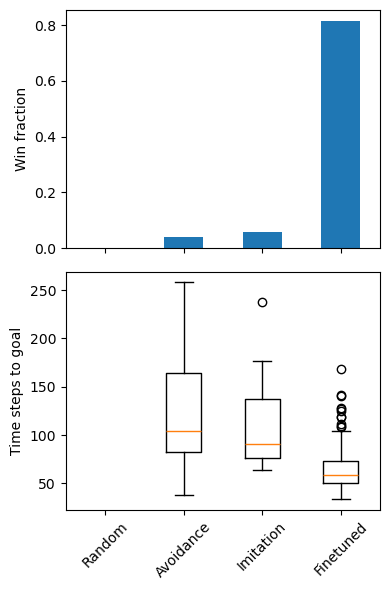

In [15]:

fig, ax = plt.subplots(2, 1, figsize=(4, 6), sharex=True)

x = np.arange(len(model_names)+1)
winrates = [0] + [np.mean(data_dict[model_name]['dones']) for model_name in model_names]
print([sum(data_dict[model_name]['dones']) for model_name in model_names])
print([len(data_dict[model_name]['dones']) for model_name in model_names])
ax[0].bar(x+1, winrates, width=0.5, align='center')
ax[0].set_xticks(x+1)
# ax[0].set_xticklabels(['Random', 'Avoidance', 'Imitation', 'Finetuned'], rotation=45)
times =  [[]] + [data_dict[model_name]['trajts'] for model_name in model_names]
ax[0].set_ylabel('Win fraction')


_ = ax[1].boxplot(times)
ax[1].set_xticks(x+1)
ax[1].set_xticklabels(['Random', 'Avoidance', 'Imitation', 'Finetuned'], rotation=45)
ax[1].set_ylabel('Time steps to goal')
fig.tight_layout()
# winrates = [np.mean(data_dict[model_name]['dones']) for model_name in model_names]
fig.savefig('data/AWAC_Performance.png', dpi=300)
    

In [16]:
51/1293 * 300

11.832946635730858

In [80]:
model_name = model_names[0]

dones = data_dict[model_name]['dones']

np.sum(dones)

1

In [81]:
len(dones)

100